In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

if "/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence" not in sys.path:
  sys.path.append("/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence/")

In [2]:
import MLP.dataManipulation as dm
import MLP.plottingFunctions as pltf

Getting the Iris dataset

In [3]:
from sklearn.datasets import load_iris

iris= load_iris()
data = iris.data

# Normalize data
data = dm.normalize_min_max(data)

## Calculate Distances

### Euclidea

In [4]:
def euclidean(x:np.ndarray , y:np.ndarray) -> float:
    return np.sqrt(np.sum((x-y)**2))

In [5]:
def euclidean_distances(data:np.ndarray) -> np.ndarray:
    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = euclidean(data[i],data[j])
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

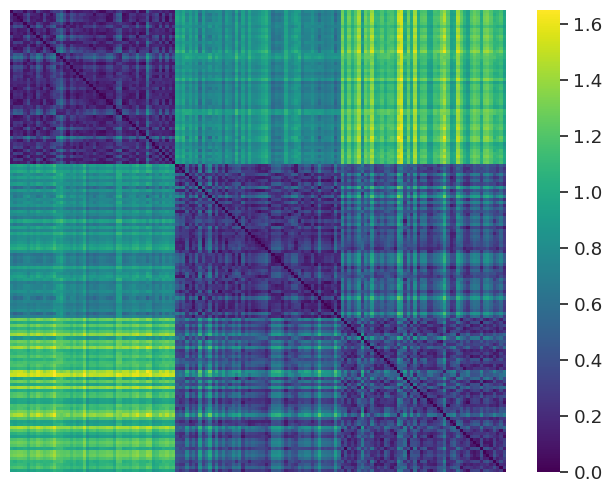

In [6]:
pltf.plot_heatmap(euclidean_distances(data))

### Mahalanobis

In [7]:
def mahalanobis(x:np.ndarray, y:np.ndarray, cov_inv:np.ndarray) -> float:
    delta = x-y
    return np.sqrt(np.dot(np.dot(delta.T, cov_inv), delta))

In [8]:
def mahalanobis_distances(data:np.ndarray, type='cov') -> np.ndarray:

    assert type in ['cov', 'MAD'], "type must be 'cov' or 'MAD'"

    n = data.shape[0]; m = data.shape[1]
    distances = np.zeros((n,n))

    if type == 'cov':
        cov =  np.array([[np.sum((x - np.mean(x)) * (y - np.mean(y))) for x in data.T] for y in data.T]) / (n-1)
        cov_inv = np.linalg.inv(cov)
        

    elif type == 'MAD':
        cov = np.array([[np.sum((x - np.median(x)) * (y - np.median(y))) for x in data] for y in data]) / (n-1)
        cov_inv = np.linalg.inv(cov)

    for i in range(n):
        for j in range(i,n):
            distance = mahalanobis(data[i],data[j], cov_inv)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

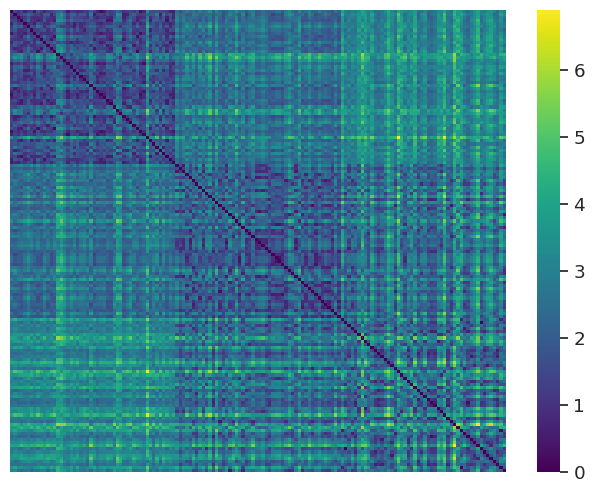

In [9]:
pltf.plot_heatmap(mahalanobis_distances(data, type='cov'))

### Manhattan

In [10]:
def manhattan(x:np.ndarray, y:np.ndarray) -> float:
    return np.sum(np.abs(x-y))

In [11]:
def manhattan_distances(data: np.ndarray) -> np.ndarray:
    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = manhattan(data[i],data[j])
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

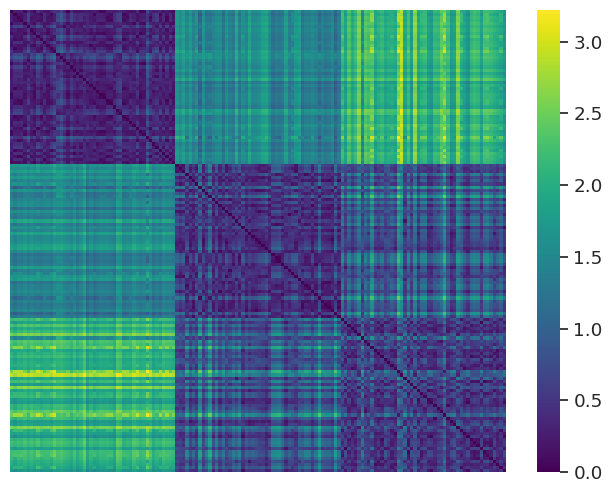

In [12]:
pltf.plot_heatmap(manhattan_distances(data))

### $\mathcal{l}_p$ 

In [13]:
def lp(x:np.ndarray, y:np.ndarray, p=1) -> float:
    if p == "inf":
        return np.max(np.abs(x-y))
    return np.sum(np.abs(x-y)**p)**(1/p)


In [14]:
def lp_distances(data:np.ndarray, p=1) -> np.ndarray:

    assert p > 0, "p must be greater than 0"
    assert type(p) == int or p == "inf", "p must be an integer or \"inf\""

    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = lp(data[i],data[j],p)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

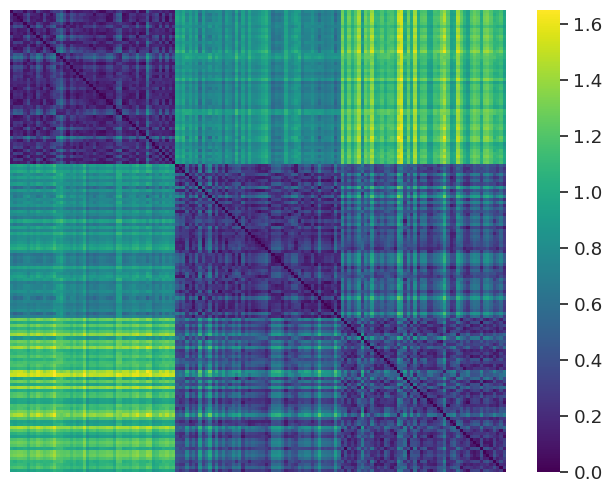

In [15]:
pltf.plot_heatmap(lp_distances(data, 2))

### Cosine semi-distance

In [16]:
def cosine(x:np.ndarray, y:np.ndarray, similarity = False) -> float:
    if similarity:
        return np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y)))
    else:
        return 1 - np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y)))

In [17]:
def cosine_distances(data:np.ndarray, similarity = False) -> np.ndarray:

    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = cosine(data[i],data[j], similarity)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

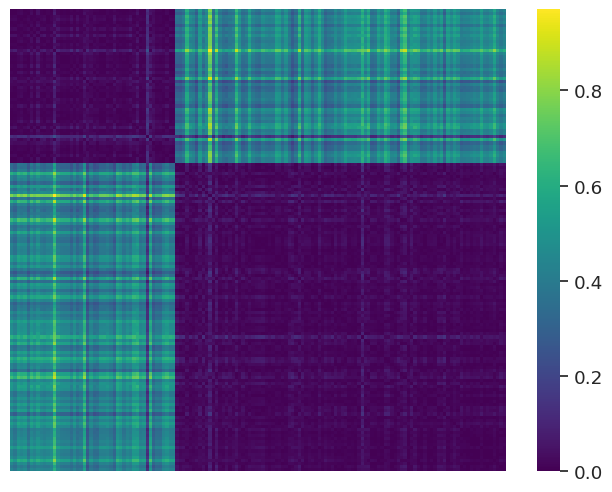

In [18]:
pltf.plot_heatmap(cosine_distances(data))

In [19]:
from scipy.cluster import hierarchy

def sort_distances(dist_matrix):
    # Perform hierarchical clustering
    linkage_matrix = hierarchy.linkage(dist_matrix, method='ward')

    # Cut the dendrogram to obtain clusters (you can adjust the threshold as needed)
    threshold = 3  # Adjust this threshold as needed
    clusters = hierarchy.fcluster(linkage_matrix, t=threshold, criterion='distance')

    # Reorder the matrix based on the cluster assignments
    sorted_indices = np.argsort(clusters)
    sorted_matrix = dist_matrix[sorted_indices][:, sorted_indices]

    return sorted_matrix

# Perform hierarchical clustering
dist_matrix = manhattan_distances(data)
sorted_matrix = sort_distances(dist_matrix)

/tmp/ipykernel_3404/116892300.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(dist_matrix, method='ward')


In [20]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage



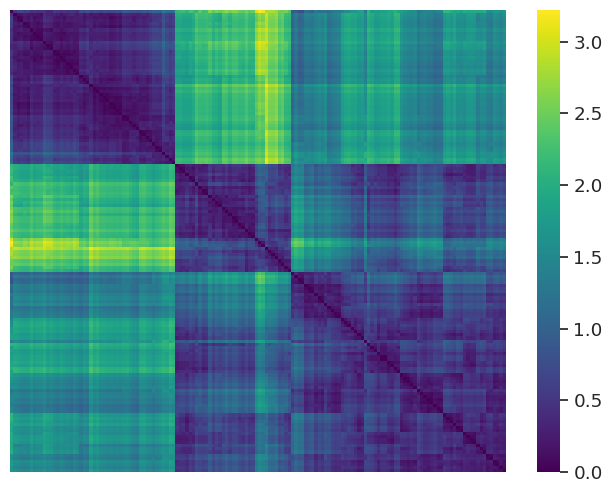

In [21]:
sorted_matrix, _, _ = compute_serial_matrix(manhattan_distances(data))
pltf.plot_heatmap(sorted_matrix)